In [1]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from datetime import datetime

# preprocessing
from tensorflow import image as tfi

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model Training
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

In [2]:
# Constants
IMAGE_SIZE = 300

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

# classnames
class_names = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

In [3]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [4]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    errors = []
    
    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            try:
                image = load_image(file_path)
                
                # Assign label
                label = class_names.index(class_name)

                # Store the image and the respective label
                images[n_image] = image
                labels[n_image] = label

                # Increment the number of images processed
                n_image += 1
                
            except:
                errors.append(file_path)
            
    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]
    
    print('num of errors:', len(errors))

    return images, labels, errors

In [5]:
# load data
test_dir = '../dataset/old/test/'

# Load the testing dataset
X_test, y_test, err_test = load_dataset(root_path = test_dir, class_names = class_names)

Loading: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


num of errors: 0


In [6]:
# load model
model_path = '../models/aksara_jawa_vgg_full_freeze_v1.h5'
model = tf.keras.saving.load_model(model_path)

# Make predictions
predictions = model.predict(X_test)
y_pred = predictions.argmax(axis=1)

38/38 [==============================] - 361s 9s/step


In [7]:
# evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f'Test loss, accuracy: {loss:.2f}, {acc:.2f}')

38/38 [==============================] - 356s 9s/step - loss: 0.8619 - accuracy: 0.9008
Test loss, accuracy: 0.86, 0.90


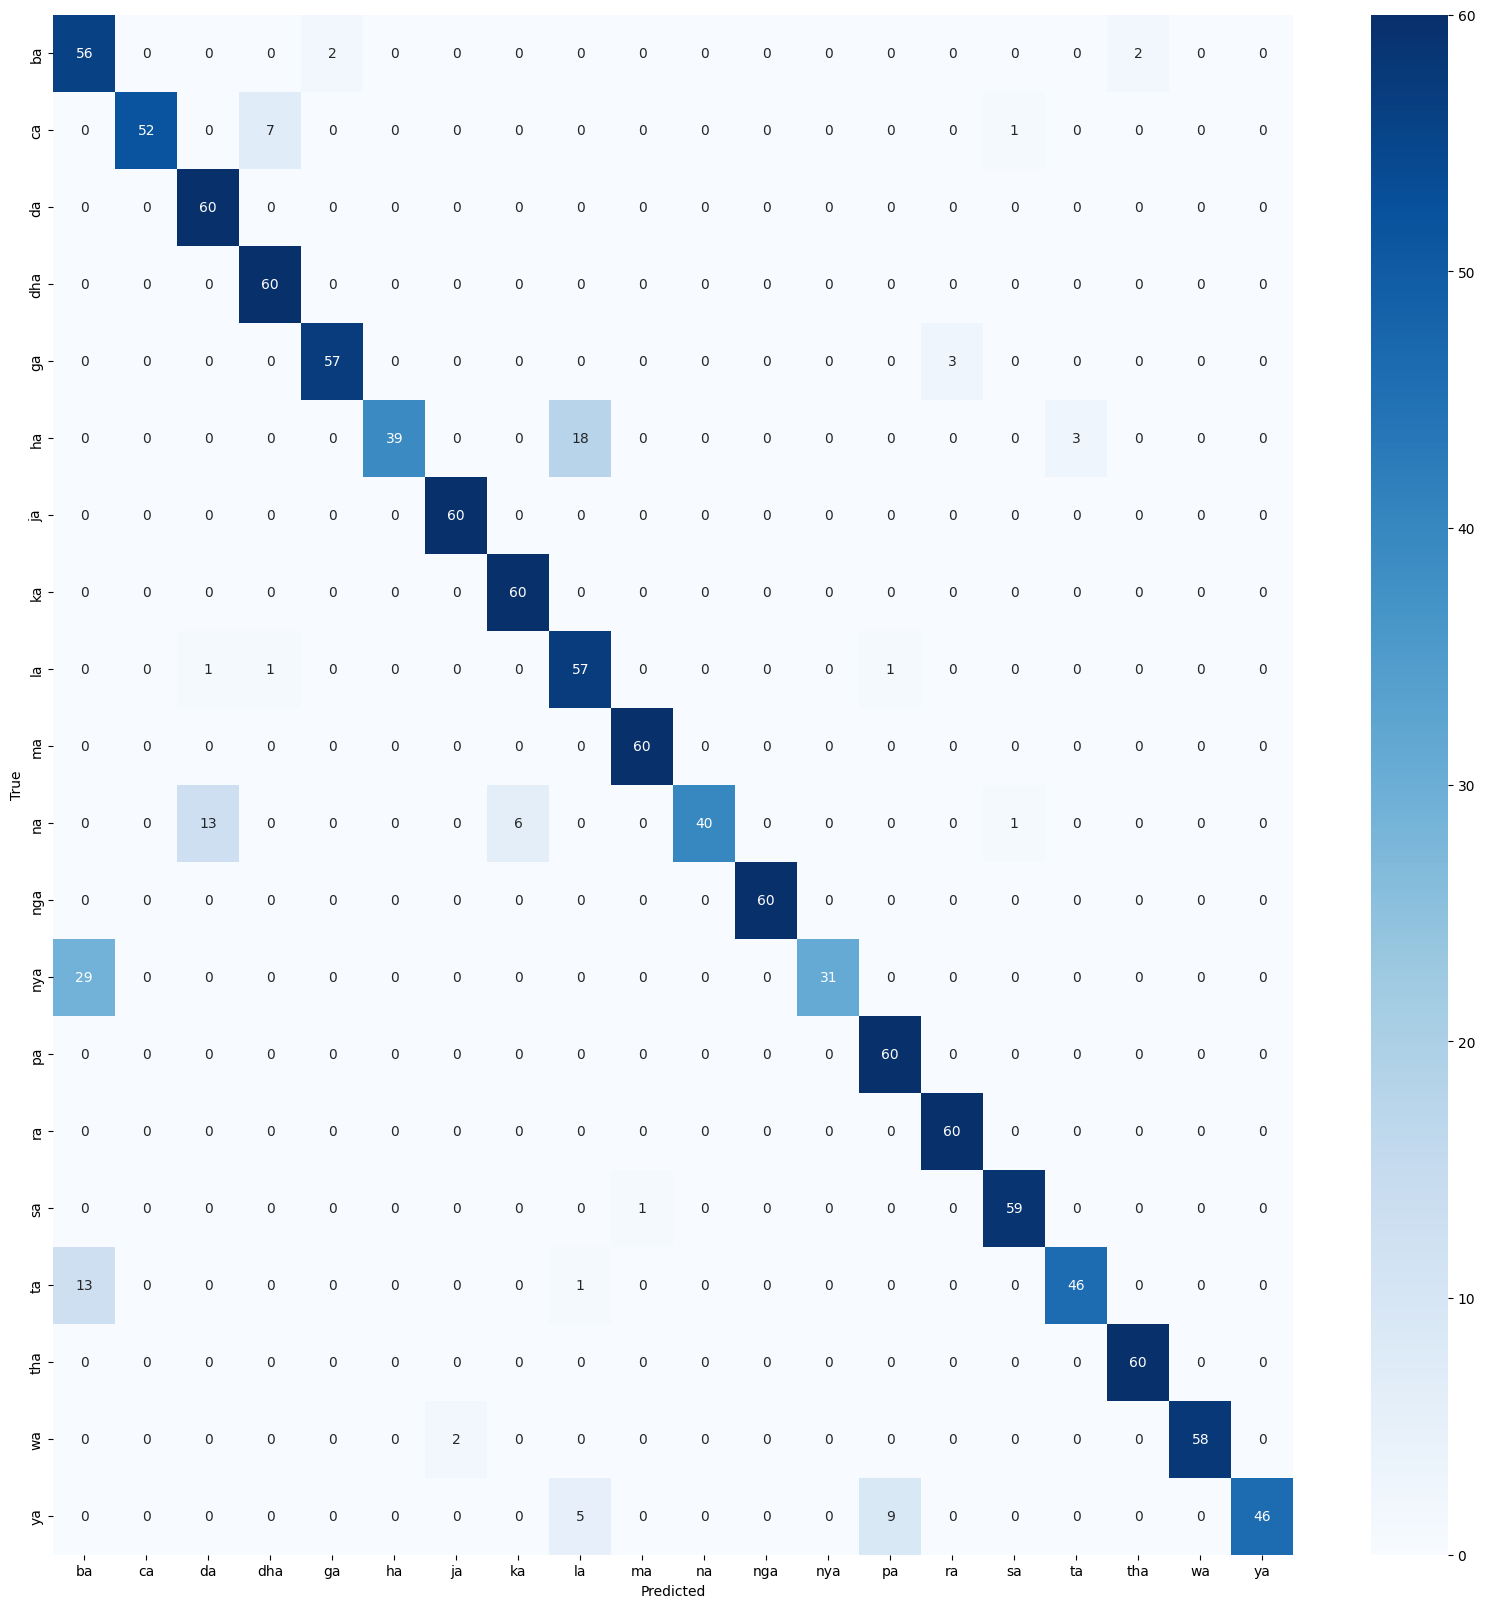

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()